In [1]:
#https://www.nature.com/articles/s41592-021-01336-8
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/src.py') as f:
    exec(f.read())
sns.set(style="whitegrid")
#torch.use_deterministic_algorithms(False)
main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/"
dataLocation="/home/jislam/Documents/gits/pancdb/T1D_T2D_public.h5ad"
single_cell_data="pancreas"
filter_by="cell_type"
categories_to_keep = 8 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=["cell_disease","sex"] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.

#MUST BE SPECIFIED FOR EACH INQUIRY. SEE BOTTOM OF SCRIPT. NEAR THE BOTTOM: when generating the full reports, you will need to specify the following parameters manually. For example.
#shared_filter = ["sex=female"] # EXACT LABEL in adata.one_hot_encoded.columns. If set to None, will not filter. if you want to specify a particular subset of cells, not of the criteria of interest (in this case sex, or race would make sense if cell_disease is what I'm interested in)
#filter_criteria_start = ["T2D"]# SMART LABEL: searches for the substring in adata.one_hot_encoded.columns. can grab all T2D with "T2D" or the specific interaction with ->["cell_disease=beta cell_T2D"] #
#filter_criteria_goal =["Control"]#SMART LABEL: same idea. ["cell_disease=beta cell_Control"]
#THESE FILTERS SHOULD BE SPECIFIED FOR EACH INQUIRY. See bottom of script.
min_optuna=3
hyperparam_epochs=10 #max per trial
hyperparam_trials=100 #number of trials for each model.
####################################

validation_ratio=0.1 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability.





sns.set(style="whitegrid")
main_path=""
validation_ratio=0.1


outdir=single_cell_data.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)




'''
adata=sc.read_h5ad(dataLocation)
adata = adata.copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.X = adata.X.toarray()

adata=adata[adata.obs["disease_state"]!="AAB"]
adata=adata[adata.obs["disease_state"]!="T1D"]
adata=adata[adata.obs["cell_type"]!="unknown"]
adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)
'''
import scanpy as sc

# 1. Read and ensure unique axes
adata = sc.read_h5ad(dataLocation).copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()

# 2. Build a single mask for all your filters
mask = (
    ~adata.obs['disease_state'].isin(['AAB', 'T1D'])  # drop AAB & T1D
    & (adata.obs['cell_type'] != 'unknown')           # drop unknown cell_type
)


# 4. If you really need a dense array, do it now
adata.X = adata.X.toarray()

# 3. Subset once and force a copy
adata = adata[mask].copy()

# 5. Create your combined metadata column
adata.obs['cell_disease'] = (
    adata.obs['cell_type'].astype(str)
    + '_'
    + adata.obs['disease_state'].astype(str)
)

selected_labels=adata.obs[filter_by].value_counts().index.to_list()[0:categories_to_keep]
adata=gosip.filter_adata_by_labels(adata,selected_labels=selected_labels,column_name=filter_by).copy()
adata.obs['cell_type']=adata.obs['cell_type'].str.replace(" ", "_", regex=False)

#fetal_adata=sc.read("/home/jislam/Documents/gits/scRNAseq_datasets/fetal_pancreas_custom_labelling.h5ad")
#fetal_adata.obs['cell_type']=fetal_adata.obs['manual_celltype_annotation']


/home/jislam/.local/lib/python3.10/site-packages/gosip/__init__.py:5: FutureWarning: In the future `np.ulong` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'ulong'):


In [2]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
#fetal_adata.X

In [4]:
adata.obs['cell_type'].unique()

array(['alpha_cell', 'mesenchymal_cell', 'endothelial_cell', 'delta_cell',
       'beta_cell', 'duct_epithelial_cell', 'acinar_cell', 'PP_cell'],
      dtype=object)

In [5]:
adata.obs

,donor_id,cell_type,assay,sex,age,race,disease_state,cell_disease
AAACCTGAGGTGTGGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control
AAACCTGCACGCCAGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control
AAACCTGCAGTCGATT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control
AAACCTGTCACATACG-2,HPAP022,mesenchymal_cell,10x 3' v2,female,39,Caucasian,Control,mesenchymal cell_Control
AAACCTGTCACCCTCA-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control
...,...,...,...,...,...,...,...,...
TTTGTTGGTAATGCTC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D
TTTGTTGGTCGTTGCG-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D
TTTGTTGGTTTAGACC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D
TTTGTTGTCGCTCTAC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D


In [6]:
#fetal_adata.obs['cell_type'].unique()

begin preprocessing...
filtering...
log(x+1) normalization...
keeping highly variable...


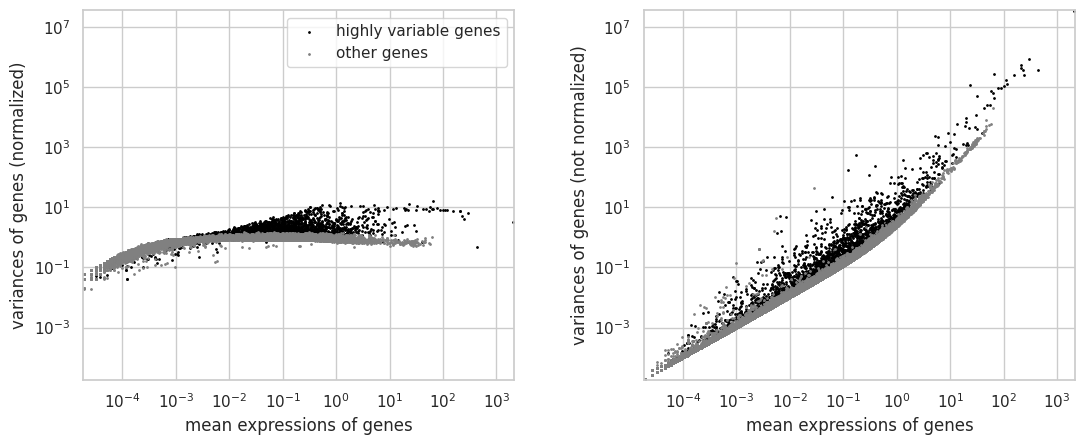

In [7]:

def pre_process(adata,top_genes=3000):
    #top_genes=int(adata.shape[1]/3)
    #top_genes=5000
    adata.layers["counts"] = adata.X.copy()
    print("begin preprocessing...")
    print("filtering...")
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    # Normalizing to median total counts
    print("log(x+1) normalization...")
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    print("keeping highly variable...")
    #sc.pp.highly_variable_genes(adata, n_top_genes=top_genes)
    sc.pp.highly_variable_genes(
    adata,
    layer='counts',         # use raw counts, not the log‐transformed X
    flavor='seurat_v3',     # mimic Seurat v3’s FindVariableFeatures(method='vst')
    n_top_genes=top_genes,  # pick your number of HVGs
    batch_key='donor_id'          # or supply a batch_key to do Seurat‐style per‐batch ranking
    )
    sc.pl.highly_variable_genes(adata,log=True)
    adata = adata[:, adata.var.highly_variable]

    return adata.copy()    

adata=pre_process(adata)
#fetal_adata.X[:,:]=fetal_adata.layers['counts'].copy()
#fetal_adata.X
#fetal_adata=pre_process(fetal_adata)


adata_filtered= adata[adata.obs['cell_type'].isin(['alpha_cell', 'delta_cell', 'beta_cell', 'PP_cell','acinar_cell'])].copy()
adata_filtered.layers['counts'].shape

adata_filtered.write("/home/jislam/Documents/gits/scRNAseq_datasets/hpap_filtered3k.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 153857 × 3000
    obs: 'donor_id', 'cell_type', 'assay', 'sex', 'age', 'race', 'disease_state', 'cell_disease', 'n_genes'
    var: 'features', 'mt', 'ribo', 'hb', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_normalization', 'cell_type_ontology_term_id_colors', 'schema_version', 'title', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts'

In [9]:
# 1. split into donor‐specific AnnDatas and record zero‐masks
import scanorama
donors = adata.obs['donor_id'].unique().tolist()
adata_list = [adata[adata.obs['donor_id']==d].copy() for d in donors]
#mask_list  = [(ad.X == 0) for ad in adata_list]

# 2. run Scanorama
corrected_list = scanorama.correct_scanpy(
    adata_list,
    batch_size   = 20000,
    return_dense = True,
    return_dimred= True,
)

## 3. re‐apply zeros in each corrected block
#for mask, cad in zip(mask_list, corrected_list):
#    cad.X[mask] = 0

# 4. safe concat
merged_adata = sc.concat(corrected_list)


Found 3000 genes among all datasets
[[0.00000000e+00 3.45588235e-01 1.97478992e-02 ... 2.18120805e-02
  5.59284116e-03 2.79642058e-04]
 [0.00000000e+00 0.00000000e+00 6.80147059e-02 ... 7.35294118e-03
  3.12500000e-02 1.10294118e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.46218487e-03
  4.62184874e-03 3.78151261e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.17787913e-01 5.27936648e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.02964652e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Processing datasets (29, 37)
Processing datasets (28, 37)
Processing datasets (33, 36)
Processing datasets (31, 37)
Processing datasets (26, 36)
Processing datasets (26, 37)
Processing datasets (3, 4)
Processing datasets (4, 5)
Processing datasets (7, 10)
Processing datasets (8, 13)
Processing datasets (28, 31)
Processing datasets (32, 35)
Processing datasets (1

In [10]:
'''
import scanorama
# get the unique donor IDs
donors = adata.obs['donor_id'].unique().tolist()

# option A: as a list, in the same order as `donors`
adata_list = [
    adata[adata.obs['donor_id'] == donor].copy()
    for donor in donors
]

scano=scanorama.correct_scanpy(adata_list, batch_size=20000,return_dense=True,return_dimred=True)

merged_adata=sc.concat(scano)
'''

"\nimport scanorama\n# get the unique donor IDs\ndonors = adata.obs['donor_id'].unique().tolist()\n\n# option A: as a list, in the same order as `donors`\nadata_list = [\n    adata[adata.obs['donor_id'] == donor].copy()\n    for donor in donors\n]\n\nscano=scanorama.correct_scanpy(adata_list, batch_size=20000,return_dense=True,return_dimred=True)\n\nmerged_adata=sc.concat(scano)\n"

In [11]:
print('done')

done


In [12]:

merged_adata= merged_adata[merged_adata.obs['cell_type'].isin(['alpha_cell', 'delta_cell', 'beta_cell', 'PP_cell','acinar_cell'])]

In [13]:
merged_adata.obs['cell_type'].unique()

array(['alpha_cell', 'delta_cell', 'beta_cell', 'acinar_cell', 'PP_cell'],
      dtype=object)

In [14]:
merged_adata.obs

,donor_id,cell_type,assay,sex,age,race,disease_state,cell_disease,n_genes
AAACCTGAGGTGTGGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,2931
AAACCTGCACGCCAGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,1172
AAACCTGCAGTCGATT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,4331
AAACCTGTCACCCTCA-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,4206
AAACCTGTCCCGACTT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,803
...,...,...,...,...,...,...,...,...,...
TTTGTTGCATGGGCAA-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,3017
TTTGTTGGTAATGCTC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,271
TTTGTTGGTCGTTGCG-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,3759
TTTGTTGGTTTAGACC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,355


In [15]:
'''
merged_adata
all_var = [x.var for x in scano]
all_var = pd.concat(all_var, join="outer")
# remove duplicates
all_var = all_var[all_var.index.duplicated()]
all_var

merged_adata.var = all_var.loc[merged_adata.var_names]


merged_adata
all_obs = [x.obs for x in scano]
all_obs = pd.concat(all_obs, join="outer")

# remove duplicates
all_obs = all_obs[~all_obs.index.duplicated()]
all_obs

merged_adata.obs = all_obs.loc[merged_adata.obs_names]
'''

'\nmerged_adata\nall_var = [x.var for x in scano]\nall_var = pd.concat(all_var, join="outer")\n# remove duplicates\nall_var = all_var[all_var.index.duplicated()]\nall_var\n\nmerged_adata.var = all_var.loc[merged_adata.var_names]\n\n\nmerged_adata\nall_obs = [x.obs for x in scano]\nall_obs = pd.concat(all_obs, join="outer")\n\n# remove duplicates\nall_obs = all_obs[~all_obs.index.duplicated()]\nall_obs\n\nmerged_adata.obs = all_obs.loc[merged_adata.obs_names]\n'

In [16]:
adata.obs

,donor_id,cell_type,assay,sex,age,race,disease_state,cell_disease,n_genes
AAACCTGAGGTGTGGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,2931
AAACCTGCACGCCAGT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,1172
AAACCTGCAGTCGATT-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,4331
AAACCTGTCACATACG-2,HPAP022,mesenchymal_cell,10x 3' v2,female,39,Caucasian,Control,mesenchymal cell_Control,3104
AAACCTGTCACCCTCA-2,HPAP022,alpha_cell,10x 3' v2,female,39,Caucasian,Control,alpha cell_Control,4206
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTAATGCTC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,271
TTTGTTGGTCGTTGCG-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,3759
TTTGTTGGTTTAGACC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,355
TTTGTTGTCGCTCTAC-67,HPAP109,acinar_cell,10x 3' v3,female,59,Hispanic,T2D,acinar cell_T2D,308


In [17]:
sc.tl.pca(merged_adata, n_comps=50)
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)

/home/jislam/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [18]:
merged_adata.obs.columns

Index(['donor_id', 'cell_type', 'assay', 'sex', 'age', 'race', 'disease_state',
       'cell_disease', 'n_genes'],
      dtype='object')

In [19]:
merged_adata.obs['cell_type']

AAACCTGAGGTGTGGT-2      alpha_cell
AAACCTGCACGCCAGT-2      alpha_cell
AAACCTGCAGTCGATT-2      alpha_cell
AAACCTGTCACCCTCA-2      alpha_cell
AAACCTGTCCCGACTT-2      alpha_cell
                          ...     
TTTGTTGCATGGGCAA-67    acinar_cell
TTTGTTGGTAATGCTC-67    acinar_cell
TTTGTTGGTCGTTGCG-67    acinar_cell
TTTGTTGGTTTAGACC-67    acinar_cell
TTTGTTGTCGCTCTAC-67    acinar_cell
Name: cell_type, Length: 131378, dtype: object

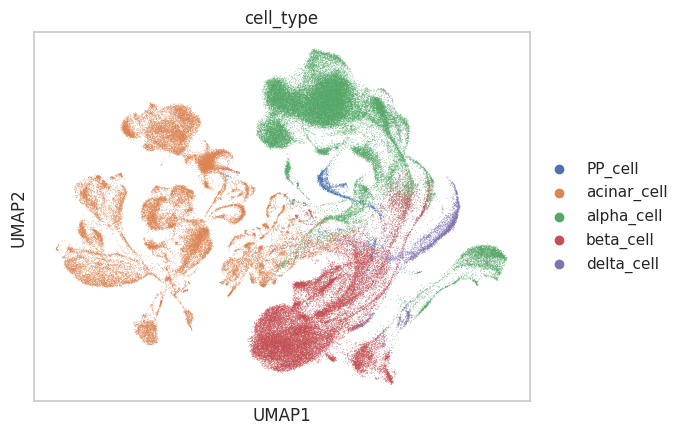

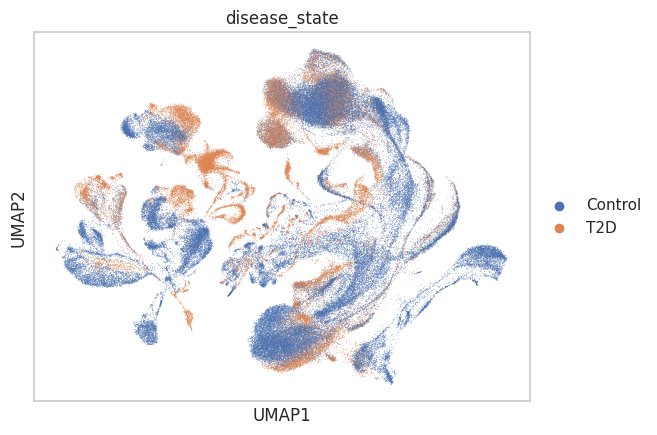

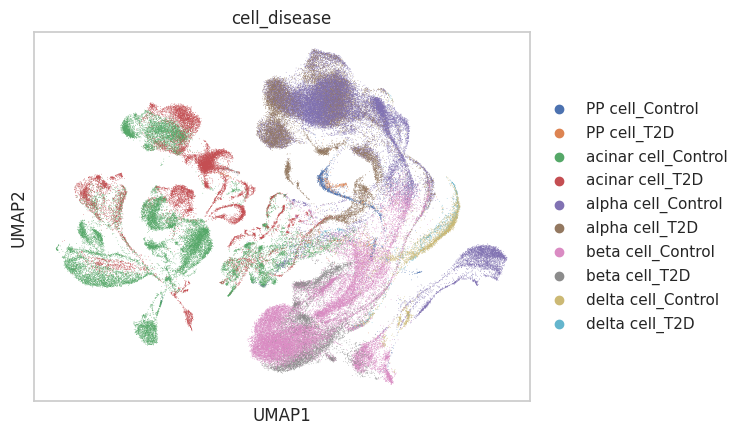

In [20]:
sc.pl.umap(merged_adata, color=["cell_type"])
sc.pl.umap(merged_adata, color=['disease_state'])
sc.pl.umap(merged_adata, color=['cell_disease'])

In [22]:
#merged_adata.var['highly_variable_intersection']=merged_adata.var['highly_variable_intersection'].astype(bool)

In [23]:
merged_adata.write("/home/jislam/Documents/gits/scRNAseq_datasets/hpap_batch_corrected.final3k.h5ad")